# Monte Carlo Search

Inspired by the [Monte Carlo Tree Refine paper](https://arxiv.org/pdf/2406.07394).

The goal is to improve the quality of responses generated by LLMs, done by:
1. Start with a seed answer, "I don't know".
2. Ask the LLM to suggest improvements to the seed answer.
3. Use the suggestions from #2 to provide three improved responses. (temp=1 --> variance)
4. Randomly select one response and use the LLM to rate that response (out of 100).
5. Calculate the UCT for the nodes (Upper Confidence bound applied to Trees) (based on the rating).
6. Traverse the tree following the nodes with the highest UCT.
7. Create new nodes (via suggestion, improvement, rating)... etc.

$$ \text{UCT} = \frac{\text{total reward of the node}}{\text{number of visits to the node}} + \text{exploration constant} \cdot \sqrt{\frac{\text{ln(number of visits to the parent node)}}{\text{number of visits to the node}}} $$

### LLM Endpoint
You can use:
- OpenAI
- Run an OpenAI compatible endpoint using a service like Runpod:
    - One click Llama 3 8b vLLM template [here](https:runpod.io/console/deploy?template=4qmr18da9x&ref=jmfkcdio).
    - Other models [here](https://github.com/TrelisResearch/one-click-llms)
- Groq
- Any other openai compatible endpoint.

In [13]:
from getpass import getpass
from dotenv import load_dotenv
import os

load_dotenv()
groq_key = os.getenv("GROQ_KEY", "Empty")

# Input the values
model = getpass("Enter the model name: ")
api_endpoint = getpass("Enter the API endpoint (default: https://api.openai.com): ")
# api_key = getpass("Enter the API key (press enter to leave empty, e.g for Runpod): ")

# Notes for Runpod:
#- Model should be the slug on HuggingFace, e.g. "NousResearch/Meta-Llama-3-8B-Instruct"
#- endpoint should be "https://{POD-ID}-8000.proxy.runpod.net", e.g. "https://yhpj2mzxpl8pcn-8000.proxy.runpod.net"

## Notes for Groq
#- Model should be "llama3-8b-8192"
#- endpoint should be "https://api.groq.com/openai"

# Set the variables with defaults
api_endpoint = api_endpoint if api_endpoint else "https://api.openai.com"
api_key = groq_key

# Construct the OpenAI API base
openai_api_base = f"{api_endpoint}/v1"

# Print the values
print(f"Model: {model}")
print(f"API Endpoint: {api_endpoint}")
print(f"OpenAI API Base: {openai_api_base}")
if api_key == "Empty":
    print("No API key needed.")
else:
    print(f"API Key Set")
    # print(f"API Key: {api_key}") # comment in to print for testing

Model: llama3-8b-8192
API Endpoint: https://api.groq.com/openai
OpenAI API Base: https://api.groq.com/openai/v1
API Key Set


In [ ]:
# # Manually update the model groq
# model = "llama3-70b-8192"
# model = "llama3-8b-8192"

In [14]:
from openai import OpenAI
import re # support for regex

# Initialize the OpenAI API client
client = OpenAI(
    api_key=api_key,
    base_url=openai_api_base
)

def chat_completion_request_openai(prompt): # function that will call the OpenAI API
    messages = [
        {"role": "user", "content": prompt}
    ]
    # Create chat completions using the OpenAI client
    chat_response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=1.0,
        max_tokens=1500,
    )

    # Extract the completion text from the response
    if chat_response.choices:
        completion_text = chat_response.choices[0].message.content
    else:
        completion_text = "No response from the model."
    return completion_text

# Test the endpoint
if __name__ == "__main__":
    # Test the function
    prompt = "Return an array of string, where each string is a season"
    chat_response = chat_completion_request_openai(prompt)
    print(f"Prompt: {prompt}\n")
    print(f"Response: {chat_response}")

Prompt: Return an array of string, where each string is a season

Response: Here is an array of string, where each string is a season:

```
["Spring", "Summer", "Autumn", "Winter"]
```


In [15]:
# Set up seed answers
seed_answers = [
    "I don't know the answer",
    "I'm not sure",
    "I can't say",
]

### Answer Improvement and Rating Pipeline
These are three steps to:
1. Critique --> get suggestions for improvement
2. Improve --> generating actual improved answers
3. Rate --> rate the improved answer (used when calculating UCT)
a given answer to a question

In [16]:
# Get Critique
def get_critique(question, draft_answer):
    prompt = (
        f"Question: {question}\n"
        f"Draft Answer: {draft_answer}\n"
        "Please critique the draft answer. "
        "Do a careful assessment of whether the answer is correct or not, and why. "
        "Consider multiple ways of verifying the correctness of the answer. "
        "Point out every flaw and hold the draft answer to a high standard. "
        "Do provide specific recommendations to improve the answer. "
        "Do think step by step."
        "Do not provide a revised answer." # Constrain the answer to be only a critique
    )
    # Create the request to the LLM
    return chat_completion_request_openai(prompt)

# test the function
if __name__ == "__main__":
    question = "What is the capital of France?"
    draft_answer = "The capital of France is Lyon." # Wrong it is Paris
    critique = get_critique(question, draft_answer)
    print(critique)

Let's critically assess the draft answer:

**Initial Assessment:** The draft answer claims that the capital of France is Lyon, but this is unlikely to be correct.

**Verification:**

1. **Simple internet search:** A quick Google search reveals that the capital of France is widely accepted to be Paris, not Lyon.
2. **Map:** Looking at a map of France, Paris is prominent as the capital, while Lyon is a major city, but not the capital.
3. **Official sources:** France's government website, official tourism websites, and other reputable sources all confirm that Paris is the capital of France.
4. **Geographic location:** Paris is located in the Île-de-France region, which is where the majority of the country's government, economy, and cultural institutions are based. Lyon, on the other hand, is located in the Auvergne-Rhône-Alpes region.

**Flaws:**

1. **Lack of reliable sources:** The draft answer relies on a single, unsubstantiated claim that Lyon is the capital of France.
2. **Inconsiste

In [17]:
import re

def improve_answer(question, draft_answer, critique):
    prompt = (
        f"Question: {question}\n"
        f"Draft Answer: {draft_answer}\n"
        f"Critique: {critique}\n\n"
        "Please improve the draft answer based on the critique. Following this format:\n"
        "Reasoning Process: <step-by-step reasoning process>\n"
        "Verfication: <verification of the facts>\n"
        "Final Answer: <the improved and verified answer>\n"
    )
    # Create the request to the LLM
    return chat_completion_request_openai(prompt)

# Test the function
if __name__ == "__main__":
    question = "What is the capital of France?"
    draft_answer = "The capital of France is Lyon." # Wrong it is Paris
    critique = "That's just wrong"
    improved_answer = improve_answer(question, draft_answer, critique)
    print(f"--Improved Answer--\n{improved_answer}\n")

--Improved Answer--
Here's an improved version:

Reasoning Process:

1. Evaluate the initial answer: The initial answer says the capital of France is Lyon, which is incorrect. Lyon is a major city in France, but it's not the capital.
2. Check the official government website: Look up the official government website of France or a reliable source to find the correct information.
3. Verify the correct answer: Use multiple sources to confirm that Paris is indeed the capital of France.

Verification:

* According to the official website of the French Government, the capital of France is indeed Paris (in French: La République Française).
* Multiple reliable sources, such as Encyclopedia Britannica, Wikipedia, and tourism websites, also confirm that Paris is the capital of France.

Final Answer: The capital of France is Paris (in French: La République Française).



In [18]:
import re

def rate_answer(question, answer):
    prompt = (
        f"Question: {question}\n"
        f"Answer: {answer}\n"
        "As an expert on this topic, please provide a detailed critique of the answer, pointing out every flaw. "
        "Provide only a critique, not a suggested answer. "
        "Then, rate the answer on a scale of 0 to 100. "
        "The response should be in the following format:\n"
        "Critique: <detailed critique>\n"
        "Rating: <rating>\n"
    )
    # Create the request to the LLM
    rating_response = chat_completion_request_openai(prompt)
    print(f"{rating_response}\n")

    # Extract the rating
    try:
        match = re.search(r"Rating:\s*(\d+)", rating_response) # Extract rating to be used in the UCT calculation
        if match:
            rating = int(match.group(1))
            if rating > 95: # Paper limits the rating to a maximum of 95 (maybe 96+ causes poor MCTS performance)
                rating = 95
            rating = float(rating)/100
        else:
            raise ValueError("Rating not found in the response.")
    except Exception as e:
        print(f"Error extracting rating: {e}")
        print(f"Rating response was: {rating_response}")
        rating = 0

    return rating

# Test the function
if __name__ == "__main__":
    question = "What is the capital of France?"
    answer = "The capital of France is Paris."
    rating = rate_answer(question, answer)
    print(f"Critique: {critique}")
    print(f"\nReward/Rating: {rating}")
    # Lower rating because of this: 
    # As an expert on this topic, please provide a detailed critique of the answer, pointing out every flaw.
    # --> Since "The capital of France is Paris." doesn't provide an explanation, it is not seen as a "good" answer.

    # Moral of the story is:
    # Rating criteria is really important and should be relaxed or tightened depending on the task. 
    # In this case, the rating criteria is too strict and penalizes good answers that are not "explanatory" enough.

Critique:

The answer is overly simplistic and lacks a critical evaluation of the topic. It is a straightforward statement of fact without providing any insight or analysis. Additionally, it does not take into account the complexity of the city's history, cultural significance, or modern-day relevance. Furthermore, the answer does not provide any supporting evidence or context to validate the assertion. Lastly, the answer does not consider alternative answers or perspectives, which is a lack of nuance and depth in its analysis.

Rating: 20

Critique: That's just wrong

Reward/Rating: 0.2


In [19]:
# Direct/Simple LLM Query
def get_answer_directly_from_llm(question): # Baseline comparison (just querying the LLM normally without any help from MTCS)
    prompt = (
        f"Question: {question}\n" # Prompting is similar to the MCTS one --> better baseline for comparison
        "Please provide the answer with detailed reasoning. Follow this format:\n"
        "Reasoning Process: <step-by-step reasoning process>\n"
        "Verification: <verification of the facts>\n"
        "Final Answer: <the verified answer>\n"
    )
    llm_response = chat_completion_request_openai(prompt)

    # Extract the final answer
    try:
        match = re.search(r'Final Answer:\s*(.*)', llm_response, re.DOTALL)
        final_answer = match.group(1).strip() if match else None
    except Exception as e:
        final_answer = None

    return llm_response, final_answer

In [20]:
import math
import random
import numpy as np

max_children = 3 # Generate 3 answers per terminal node reached
# To increase the variance at each node --> increase max_children

class Node:
    def __init__(self, question, answer, parent=None):
        self.question = question
        self.answer = answer
        self.parent = parent
        self.children = []
        self.visits = 0 # Number of times we consider a child of this node (since we will backpropogate the reward to all the parents of that child)
        self.value = 0.0 # Accumulated reward (everytime we evaluate a child node --> we will backpropogate/update the value of all of its parents by adding it to the parent's current value (accumulated reward))
    
    def is_fully_expanded(self): # Have we created the maximum number of children for this node? --> if yes, we will not expand it anymore
        return len(self.children) >= max_children
    
    def best_child(self, exploration_weights=1.41): # Used to determine what path we want to follow in the tree (we always want to follow the best child path)
        choices_weights = []
        for child in self.children:
            if child.visits == 0:
                weight = float('inf') # Prioritize unexplored nodes
            else:
                weight = (child.value / child.visits) + exploration_weights * math.sqrt(2 * math.log(self.visits) / child.visits) # UCT calculation
                # Exploration term --> (child.value / child.visits) --> basically the average reward of the child
                # Exploitation term --> exploration_weights * math.sqrt(2 * math.log(self.visits) / child.visits) --> will be very high for unexplored nodes which will encourage exploration down that path
            choices_weights.append(weight)
        return self.children[np.argmax(choices_weights)] # Return the child with the highest UCT value
    
    def most_visited_child(self): # This is used to pull the best trajectory from the MCTS tree once its generation is done (best trajectory == most likely to be the correct answer)
        return max(self.children, key=lambda child: child.visits) # Return the child with the most visits
    
    def add_child(self, child_node): # Utility function used to expand the tree
        self.children.append(child_node)
    
class MCTS:
    def __init__(self, question, seed_answers, iterations=2):
        self.question = question
        self.seed_answers = seed_answers
        self.iterations = iterations # Number of times that we will go through the full process of: generating children, evaluating one of them, and propagating back the reward
        self.root = Node(question, random.choice(seed_answers)) # Randomly select a seed answer to start with

    def search(self):
        for i in range(self.iterations):
            print(f"\nIteration {i+1}/{self.iterations}")
            node = self.select(self.root) # Select a node to expand
            print(f"Selected node: {node.answer}")
            if not node.is_fully_expanded():
                node = self.expand(node) # Expand the ndode
                print(f"\nExpanded node: {node.answer}")
            reward = self.simulate(node) # Simulate one of the expanded children
            print(f"\nSimulated reward: {reward}")
            self.backpropagate(node, reward) # Backpropogate the reward of the simulated child 
        print(f"Visits to most visited child: {self.root.most_visited_child().visits}")
        return self.root.most_visited_child().answer
    
    def select(self, node): # While nodes are fully expanded, move down the path generated by the nodes with the highest UCT value (best child)
        while node.is_fully_expanded() and node.children:
            node = node.best_child()
        return node
    
    def expand(self, node):
        for j in range(max_children - len(node.children)): # Repeat for 3 children nodes
            child_node = Node(self.question, node.answer, parent=node) # Initialize the child node with the same question and answer as the parent node
            node.add_child(child_node)

            critique = get_critique(self.question, child_node.answer) # Get the critique of the child node's answer (answer is the same as the parent node)
            print(f"\n--Critique {j}--\n{critique}")

            improved_answer = improve_answer(self.question, child_node.answer, critique) # Get the improved answer of the child node with the critique
            print(f"\n--Improved Answer {j}--\n{improved_answer}")

            child_node.answer = improved_answer # Updated the child node's answer with the improved answer
        return random.choice(node.children) # Randomly select one of the children to simulate (this is the child who's reward will backpropogate) (this is the standard simulation protocol for MCTS)
    
    def simulate(self, node):
        rating = rate_answer(self.question, node.answer) # Get the rating of the child node's answer through the LLM (not true simulation)
        return rating # This will be backpropogated to all parent nodes of the current node
    
    def backpropagate(self, node, reward):
        while node is not None:
            node.visits += 1
            node.value += reward
            print(f"Backpropagating reward {reward} to node: {node.answer}")
            node = node.parent # Move up the tree to the parent node


# Set the question and seed answers
question = "What is the capital of France?"

# Initialize and run MCTS
mcts = MCTS(question, seed_answers, iterations=2) # 2 iterations for testing
best_answer = mcts.search() # Main function that runs the MCTS algorithm
print(f"\nBest Answer: {best_answer}")


Iteration 1/2
Selected node: I can't say

--Critique 0--
Draft Assessment:

The draft answer is: "I can't say"

Critique:

* The draft answer lacks substance and doesn't provide any information about the capital of France.
* It seems to be an avoidance mechanism rather than a honest attempt to answer the question.
* The answer is not correct, as it's not a factual statement about the capital of France, but rather a noncommittal response.

Verification:

* Checking online resources such as Wikipedia, government websites, and travel guides would provide accurate information about the capital of France, which is Paris.
* Consulting encyclopedias, books, or atlases would also provide confirmatory evidence.
* Conducting a simple internet search using search engines would yield Paris as the correct answer.

Flaws:

* Lack of research and effort to provide an accurate answer.
* Failure to provide a clear and concise response.
* Inability to acknowledge uncertainty or lack of knowledge while 

In [21]:
import pandas as pd
from datasets import load_dataset # library to load datasets, part of HuggingFace
import re

def extract_boxed_answer(answer):
    """
    Extracts the content within the last \boxed{} in the answer, handling nested braces.
    """
    pattern = re.compile(r'\\boxed{((?:[^{}]|\{(?:[^{}]|\{[^{}]*\})*\})*)}')
    matches = pattern.findall(answer)
    if matches:
        return matches[-1]  # Return the last match
    return None

def get_MATH_DA(row_number=None): # Question Answer Dataset
    # Load the dataset
    dataset = load_dataset("DigitalLearningGmbH/MATH-lighteval", 'number_theory', split='test[:100]')
    # 'default', 'algebra', 'counting_and_probability', 'geometry', 'intermediate_algebra', 'number_theory', 'prealgebra', 'precalculus'

    # Convert to pandas DataFrame for easier manipulation
    df = pd.DataFrame(dataset)

    # If no row number is provided, ask the user to input a row number
    if row_number is None:
        row_number = int(input("Please enter a row number (0-99): "))

    # Ensure the row number is within the valid range
    if row_number < 0 or row_number >= len(df):
        raise ValueError(f"Row number must be between 0 and 99.")
    
    # Get the selected row
    selected_row = df.iloc[row_number]

    # Extract the question and answer
    question = selected_row['problem']
    full_answer = selected_row['solution']
    short_answer = extract_boxed_answer(full_answer) # Extract the boxed answer from the full answer

    return question, full_answer, short_answer

In [34]:
# Direct querying (no MCTS) --> used for baseline comparison
# Fetch a question, full answer, ans short answer using the existing function
question, full_answer, short_answer = get_MATH_DA()

# Print the fecthed question and answers
print("**Question**", question)

# Get the answer directly from the LLM
llm_full_answer, llm_short_answer = get_answer_directly_from_llm(question)

# Compare the LLM result to the actual short answer (given by the dataset)
print(f"\n**Direct LLM Query Answer**: {llm_full_answer}")
print(f"\n**Ground Truth Short Answer**: {short_answer}")
print(f"\n**Ground Truth Full Answer**: {full_answer}")


train-00000-of-00001.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/182k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/869 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/540 [00:00<?, ? examples/s]

**Question** A stadium staircase with 150 steps is numbered from 1 to 150. Jan starts on step 130 and steps down to step number 127, then to step number 124, and continues downward to step 13 stepping only on every third step. Jen starts on step number 3 and steps up to step number 7, then to step number 11, and continues upward to step 139 stepping only on every fourth step. How many steps were stepped on by both Jan and Jen (not necessarily at the same time)?

**Direct LLM Query Answer**: Reasoning Process:

Let's break down the problem into two parts: Jan's staircase and Jen's staircase.

Jan's staircase:

Jan starts at step 130 and steps down to step 127, then to step 124, and so on. Since she's stepping down every three steps, she'll reach the next step by decrementing the current step by 3.

Jan's steps: 130, 127, 124, ..., 13

To find the number of steps Jan takes, we can use the formula:

Number of steps = (initial step - final step) / 3 + 1

Jan starts at step 130 and ends at 

In [ ]:
# Fetch a question, full answer, and short answer using the existing function
question, full_answer, short_answer = get_MATH_DA()

# Print the fetched question and answers
print("\n**Fetched Question**", question)

# Initialize and run MCTS with the fetched question
mcts = MCTS(question, seed_answers, iterations=10)
best_answer = mcts.search()

# Comppare the MCTS result to the actual short answer (given by the dataset)
print('\n')
print(f"\n**MCTS Best Answer**: {best_answer}")
print(f"\n**Ground Truth Short Answer**: {short_answer}")
print(f"\n**Ground Truth Full Answer**: {full_answer}")

## Limitations of running MTCS this way

- Correctness is not gauranteed when using an LLM as a judge
    - Depends on training/data of the LLM you are querying

- Monte Carlo requires many iterations (to be accurate)
    - Slow responses
    - Expensive

==> Best for high latency (low latency -->  chat bot), high quality tasks (example 1 time dataset creation, not good for synchronous use)

==> Better judges for quantative fields could be to run a Python program (code augmentation) to verify the correctness of the response --> use this is either provide or augment the rating/reward (or short-circuit the process if you have reached the correct answer)

==> If you are using a LLM as a judge it can only be good in domains it has knowledge of (if not it will not aid you in the exploration, providing poor rewards)

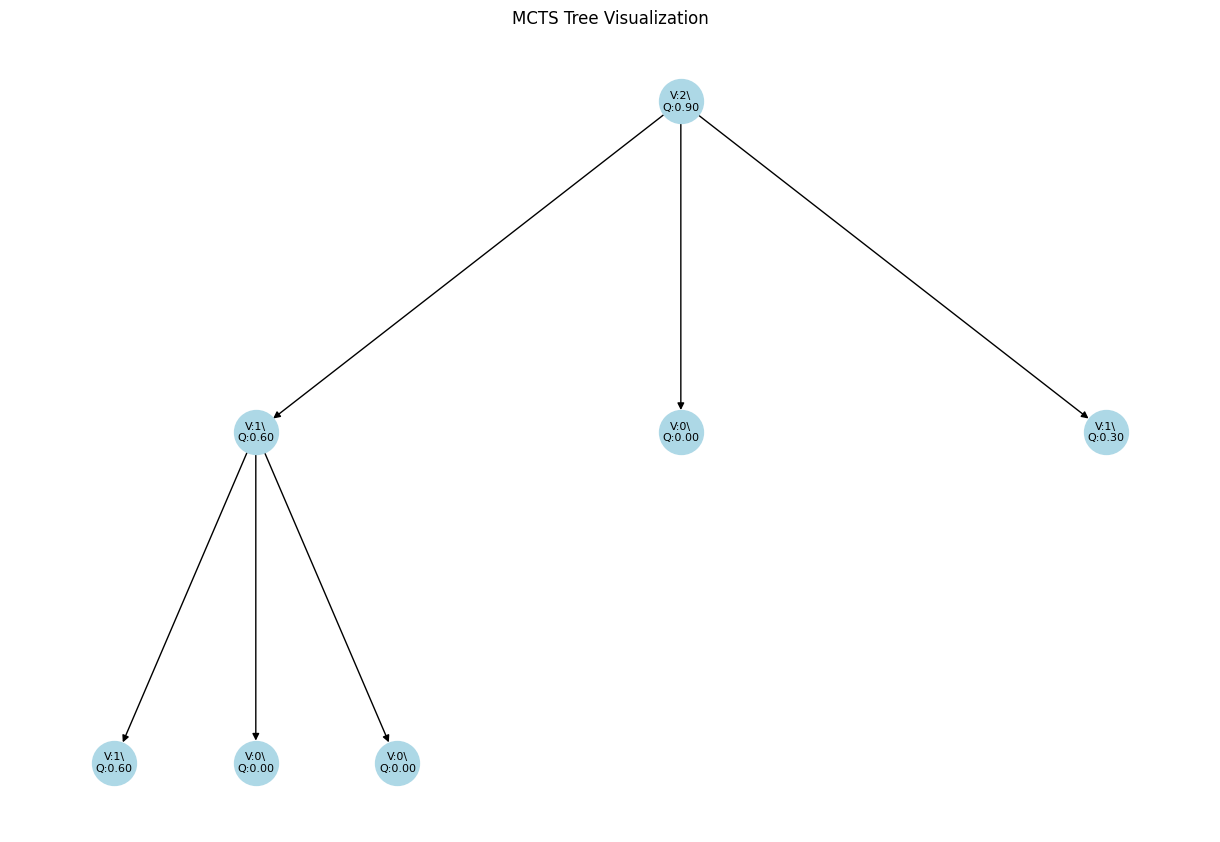

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Tidy tree layout algorithm --> Reingold-Tilford layout
def tidy_tree_layout(tree, root=None, x=0, y=0, dx=1.0, positions=None, level=0, spacing=1.5):
    if positions is None:
        positions = {}
    positions[root] = (x, y)
    children = list(tree.successors(root))
    if children:
        width = dx * (len(children) - 1) * spacing
        next_x = x - width / 2
        for child in children:
            tidy_tree_layout(tree, child, next_x, y - 1, dx / 3, positions, level + 1, spacing)
            next_x += dx * spacing
    return positions

def visualize_mcts_tree(mcts, max_nodes=100):
    graph = nx.DiGraph()
    node_labels = {}
    node_counter = [0]
    node_ids = {}

    def add_edges(node, parent_id=None):
        if node_counter[0] >= max_nodes:
            return
        node_id = node_counter[0]
        node_counter[0] += 1
        node_ids[node] = node_id
        label = f"V:{getattr(node, 'visits', '?')}\\\nQ:{getattr(node, 'value', '?'):.2f}"
        node_labels[node_id] = label
        graph.add_node(node_id)
        if parent_id is not None:
            graph.add_edge(parent_id, node_id)
        for child in getattr(node, 'children', []):
            add_edges(child, node_id)

    add_edges(mcts.root)
    pos = tidy_tree_layout(graph, root=0, dx=2.0, spacing=1.5)
    plt.figure(figsize=(12, 8))
    nx.draw(
        graph,
        pos,
        with_labels=False,
        node_size=1000,  # Reduced node size
        node_color="lightblue"
    )
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=8)  # Reduced font size
    plt.title("MCTS Tree Visualization")
    plt.axis('off')
    plt.show()

# Example usage
visualize_mcts_tree(mcts)